# **EDA**

In [166]:
# @title Loading and merging datasets { form-width: "20px" }
import pandas as pd

#Load all the datasets
df_sales = pd.read_excel('/content/ProductA.xlsx')
df_facebook = pd.read_excel('/content/ProductA_fb_impressions.xlsx')
df_google = pd.read_excel('/content/ProductA_google_clicks.xlsx')

#Merge based on common column
merged_df = df_sales.merge(df_facebook, on='Day Index', how='left').merge(df_google, on='Day Index', how='left')
merged_df.head()

,Day Index,Quantity,Impressions,Clicks
0,2021-12-01,14,620,445
1,2021-12-02,10,890,433
2,2021-12-03,13,851,424
3,2021-12-04,22,881,427
4,2021-12-05,33,678,451


In [167]:
# @title Total duration and start & end dates of dataset { form-width: "20px" }
merged_df['Day Index'] = pd.to_datetime(merged_df['Day Index'])

min_date = merged_df['Day Index'].min()
max_date = merged_df['Day Index'].max()

duration = max_date - min_date

print(f"The dataset covers the period from {min_date} to {max_date}.")
print(f"The total duration is {duration.days} days.")


The dataset covers the period from 2021-12-01 00:00:00 to 2022-06-30 00:00:00.
The total duration is 211 days.


In [168]:
# @title Information about data { form-width: "20px" }
df1 = df_sales
df2 = df_facebook
df3 = df_google

merged_df1 = pd.merge(df1, df2, on='Day Index')
merged_df = pd.merge(merged_df1, df3, on='Day Index')

rows, columns = merged_df.shape
column_names = merged_df.columns

print(f"Total number of rows: {rows}")
print(f"Total number of columns: {columns}")
print(column_names)
print(merged_df.info())

Total number of rows: 212
Total number of columns: 4
Index(['Day Index', 'Quantity', 'Impressions', 'Clicks'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day Index    212 non-null    datetime64[ns]
 1   Quantity     212 non-null    int64         
 2   Impressions  212 non-null    int64         
 3   Clicks       212 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.8 KB
None


In [169]:
# @title Missing values { form-width: "20px" }
missing_values = merged_df.isnull().sum()
print(missing_values)


Day Index      0
Quantity       0
Impressions    0
Clicks         0
dtype: int64


No missing values in the dataset. The output indicates that the count of missing values for each column (Day Index, Quantity, Impressions, Clicks) is 0, which means that the dataset is complete and there are no null or missing values.

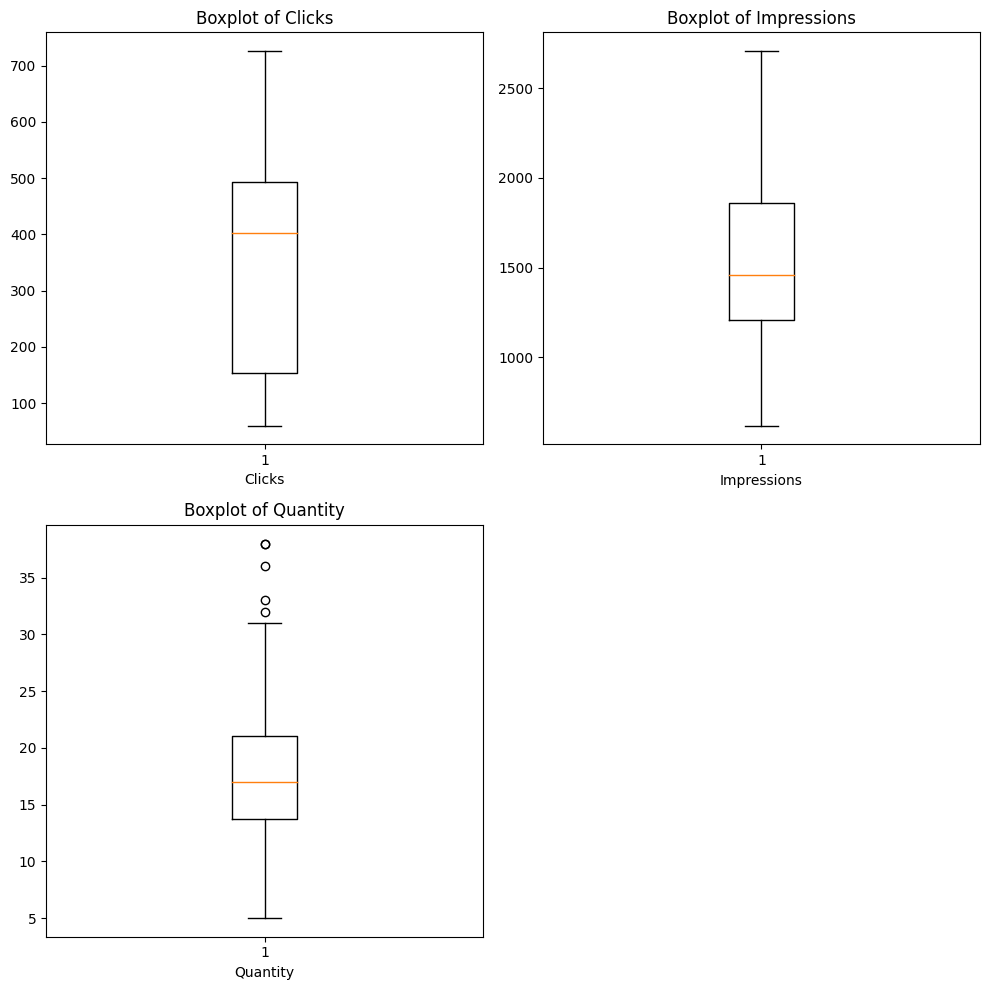

In [170]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 10))

# Boxplot for Clicks
plt.subplot(2, 2, 1)
plt.boxplot(merged_df['Clicks'])
plt.title('Boxplot of Clicks')
plt.xlabel('Clicks')

# Boxplot for Impressions
plt.subplot(2, 2, 2)
plt.boxplot(merged_df['Impressions'])
plt.title('Boxplot of Impressions')
plt.xlabel('Impressions')

# Boxplot for Quantity
plt.subplot(2, 2, 3)
plt.boxplot(merged_df['Quantity'])
plt.title('Boxplot of Quantity')
plt.xlabel('Quantity')

# Adjust layout
plt.tight_layout()

# Display plot
plt.show()


From above graphs we conclude, no outliers present in clicks and impressions dataset. Quantity dataset contains outliers with values above 30

   Quantity  quantity1  Impressions  Clicks
0        14      14.00          620     445
1        10      10.00          890     433
2        13      13.00          851     424
3        22      22.00          881     427
4        33      30.67          678     451


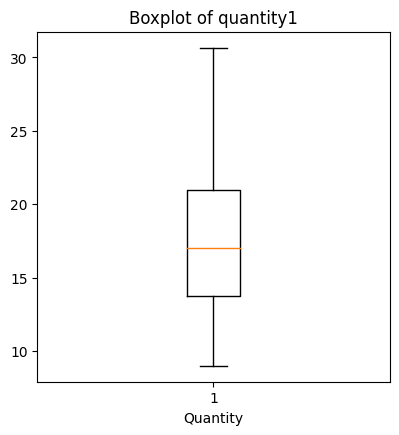

In [171]:
# @title Outlier Imputation { form-width: "20px" }
def cap_outliers(df, column, lower_percentile=0.05, upper_percentile=0.99):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    capped_column = df[column].apply(lambda x: upper_bound if x > upper_bound else lower_bound if x < lower_bound else x)
    return capped_column
# Create imputed quantity1 column
merged_df['quantity1'] = cap_outliers(merged_df, 'Quantity', lower_percentile=0.05, upper_percentile=0.97)
# Display the first few rows to verify
print(merged_df[['Quantity', 'quantity1', 'Impressions', 'Clicks']].head())

plt.figure(figsize=(10, 10))
# Boxplot for quantity1
plt.subplot(2, 2, 1)
plt.boxplot(merged_df['quantity1'])
plt.title('Boxplot of quantity1')
plt.xlabel('Quantity')
plt.show()

Outliers from Quantity dataset are imputed and new column quantity1 is created with imputed data values.

In [172]:
# @title Feature engineering { form-width: "20px" }

import pandas as pd
import numpy as np

# Convert 'Day Index' to datetime if it's not already
# merged_df['Day Index'] = pd.to_datetime(merged_df['Day Index'])

# Set 'Day Index' as the index
merged_df = merged_df.set_index('Day Index')

# Extract features from the date
merged_df['Year'] = merged_df.index.year
merged_df['Month'] = merged_df.index.month
merged_df['Quarter'] = merged_df.index.quarter
merged_df['Weekday'] = merged_df.index.dayofweek

# Determine if the day is a weekend
merged_df['Is Weekend'] = merged_df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)  # 1 if Saturday (5) or Sunday (6)

# Dummy feature for holiday (for example purposes, assuming holidays are on specific dates)
holidays = ['2021-12-25', '2021-12-31']
merged_df['Is Holiday'] = merged_df.index.isin(pd.to_datetime(holidays)).astype(int)

# If there's a typo, correct it before grouping
merged_df['Day Type'] = 'Weekday'  # Assuming this line is correct
merged_df.loc[merged_df['Is Weekend'] == 1, 'Day Type'] = 'Weekend'
merged_df.loc[merged_df['Is Holiday'] == 1, 'Day Type'] = 'Holiday'

# Now group by the correct column name
day_type_summary = merged_df.groupby('Day Type')['quantity1'].sum()  # Calculate sum (change to mean for average)

# Sales per Impression
merged_df['Sales_per_Impression'] = merged_df['quantity1'] / merged_df['Impressions']

# Sales per Click
merged_df['Sales_per_Click'] = merged_df['quantity1'] / merged_df['Clicks']

# Lag Features
merged_df['Quantity_Lag1'] = merged_df['quantity1'].shift(1)
merged_df['Quantity_Lag7'] = merged_df['quantity1'].shift(7)

# Aggregates
monthly_aggregate = merged_df.resample('M').sum()
daily_aggregate = merged_df.resample('D').sum()
quarterly_aggregate = merged_df.resample('Q').sum()

# Aggregate data by weekday
weekday_aggregate = merged_df.groupby('Weekday').agg({'quantity1': 'sum'})

# Map weekdays and months to 1 where applicable
for i, day in enumerate(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']):
    merged_df[f'Weekday_{day}'] = (merged_df['Weekday'] == i).astype(int)

for i, month in enumerate(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']):
    merged_df[f'Month_{month}'] = (merged_df['Month'] == i+1).astype(int)

# Fill NaNs with 0 for newly created columns
weekday_columns = [f'Weekday_{day}' for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
month_columns = [f'Month_{month}' for month in ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']]
merged_df[weekday_columns + month_columns] = merged_df[weekday_columns + month_columns].fillna(0)

# Display the first few rows to verify
print(merged_df.head())



            Quantity  Impressions  Clicks  quantity1  Year  Month  Quarter  \
Day Index                                                                    
2021-12-01        14          620     445      14.00  2021     12        4   
2021-12-02        10          890     433      10.00  2021     12        4   
2021-12-03        13          851     424      13.00  2021     12        4   
2021-12-04        22          881     427      22.00  2021     12        4   
2021-12-05        33          678     451      30.67  2021     12        4   

            Weekday  Is Weekend  Is Holiday  ... Month_March  Month_April  \
Day Index                                    ...                            
2021-12-01        2           0           0  ...           0            0   
2021-12-02        3           0           0  ...           0            0   
2021-12-03        4           0           0  ...           0            0   
2021-12-04        5           1           0  ...           0        

In [173]:
print(merged_df.columns)

Index(['Quantity', 'Impressions', 'Clicks', 'quantity1', 'Year', 'Month',
       'Quarter', 'Weekday', 'Is Weekend', 'Is Holiday', 'Day Type',
       'Sales_per_Impression', 'Sales_per_Click', 'Quantity_Lag1',
       'Quantity_Lag7', 'Weekday_Monday', 'Weekday_Tuesday',
       'Weekday_Wednesday', 'Weekday_Thursday', 'Weekday_Friday',
       'Weekday_Saturday', 'Weekday_Sunday', 'Month_January', 'Month_February',
       'Month_March', 'Month_April', 'Month_May', 'Month_June', 'Month_July',
       'Month_August', 'Month_September', 'Month_October', 'Month_November',
       'Month_December'],
      dtype='object')


<ipython-input-174-027608d17b4a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_aggregate.index, y=weekday_aggregate['quantity1'], palette='viridis')


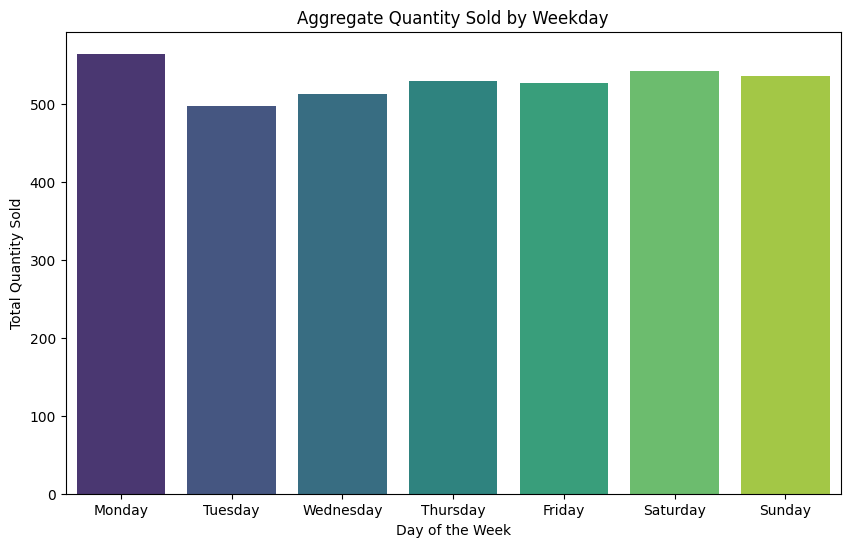

In [174]:
# @title Aggregate quantity sold by weekday { form-width: "20px" }
import matplotlib.pyplot as plt
import seaborn as sns
# Map weekday numbers to names for better readability
weekday_aggregate.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plotting the aggregate data
plt.figure(figsize=(10, 6))
sns.barplot(x=weekday_aggregate.index, y=weekday_aggregate['quantity1'], palette='viridis')
plt.title('Aggregate Quantity Sold by Weekday')
plt.xlabel('Day of the Week')
plt.ylabel('Total Quantity Sold')
plt.show()

Monday has the highest quantity sold, followed by Sunday, Saturday, Thursday, Friday, Wednesday, and then Tuesday.
The chart suggests that the company sells the most on Mondays and Sundays.

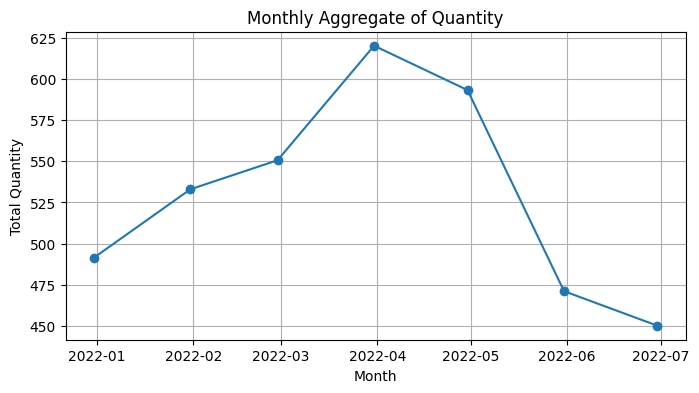

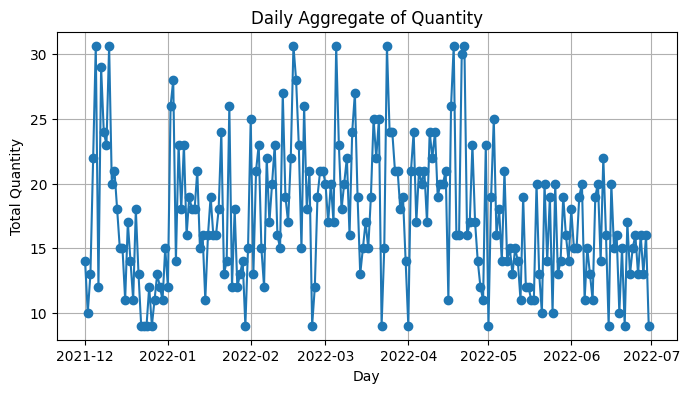

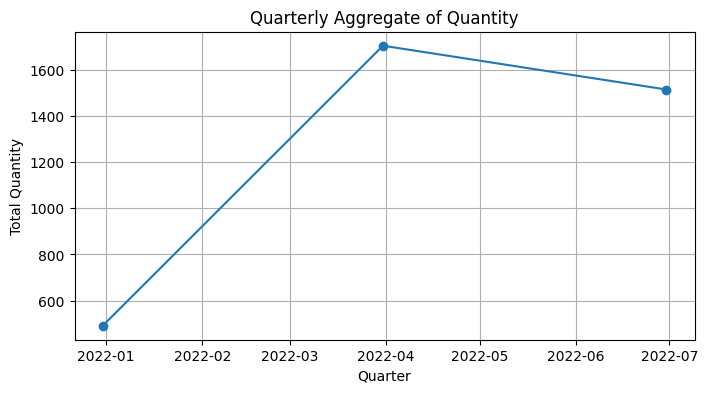

In [175]:
# @title Monthly, daily and quarterly aggregate of quantity { form-width: "20px" }

import pandas as pd

# Plot Monthly Aggregate
plt.figure(figsize=(8, 4))
plt.plot(monthly_aggregate.index, monthly_aggregate['quantity1'], marker='o', linestyle='-')
plt.title('Monthly Aggregate of Quantity')
plt.xlabel('Month')
plt.ylabel('Total Quantity')
plt.grid(True)
plt.show()

# Plot Daily Aggregate
plt.figure(figsize=(8, 4))
plt.plot(daily_aggregate.index, daily_aggregate['quantity1'], marker='o', linestyle='-')
plt.title('Daily Aggregate of Quantity')
plt.xlabel('Day')
plt.ylabel('Total Quantity')
plt.grid(True)
plt.show()

# Plot Quarterly Aggregate
plt.figure(figsize=(8, 4))
plt.plot(quarterly_aggregate.index, quarterly_aggregate['quantity1'], marker='o', linestyle='-')
plt.title('Quarterly Aggregate of Quantity')
plt.xlabel('Quarter')
plt.ylabel('Total Quantity')
plt.grid(True)
plt.show()


1. The plot shows the monthly aggregate of quantity for the year 2022. The quantity was highest in April, and the lowest in July.

2. The graph shows the daily aggregate of quantity for a certain product. There are some notable patterns, such as a spike in quantity in December 2021, followed by a dip in January 2022. There is also a general upward trend in quantity from March to June 2022. Overall, the graph suggests that there is some seasonality in the demand for this product, with higher demand in the winter months and lower demand in the summer months. However, there are also some significant fluctuations in quantity that may be due to other factors, such as promotions or changes in consumer behavior.

3. The line chart shows a quarterly aggregate of quantity. The quantity increases from Q1 2022 to Q2 2022, reaches a peak in Q3 2022 and then decreases slightly in Q4 2022.

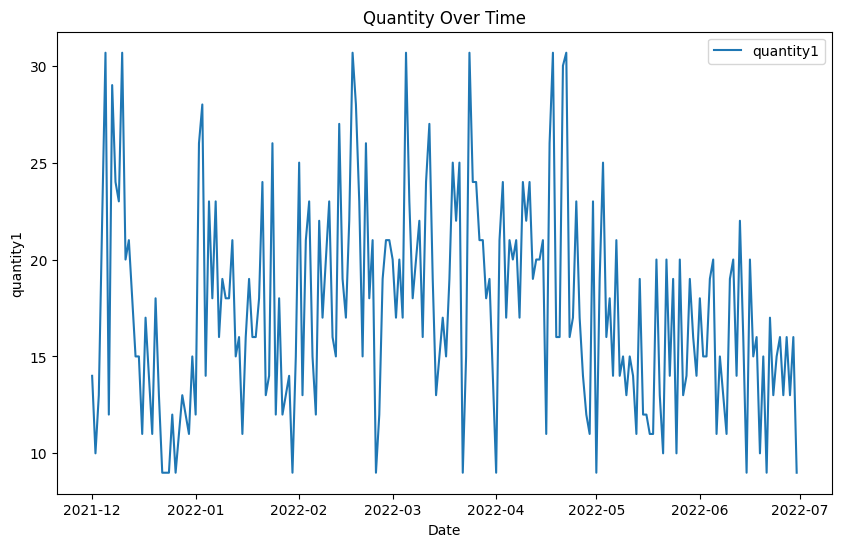

In [176]:
# @title Quantity over time { form-width: "20px" }
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(merged_df.index, merged_df['quantity1'], label='quantity1')
plt.title('Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('quantity1')
plt.legend()
plt.show()


The highest quantity of sales were in March and April 2022, while the lowest quantity sales were in December 2021.

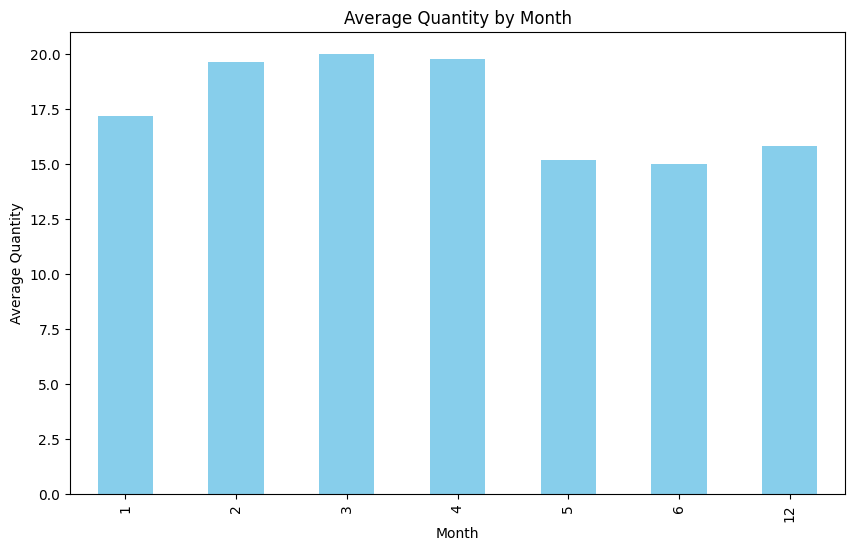

In [177]:
# @title Quantity by month { form-width: "20px" }
plt.figure(figsize=(10, 6))
merged_df.groupby('Month')['quantity1'].mean().plot(kind='bar', color='skyblue')
plt.title('Average Quantity by Month')
plt.xlabel('Month')
plt.ylabel('Average Quantity')
plt.show()


The average quantity of items sold in month 4 is the highest, followed by month 3, and month 2.

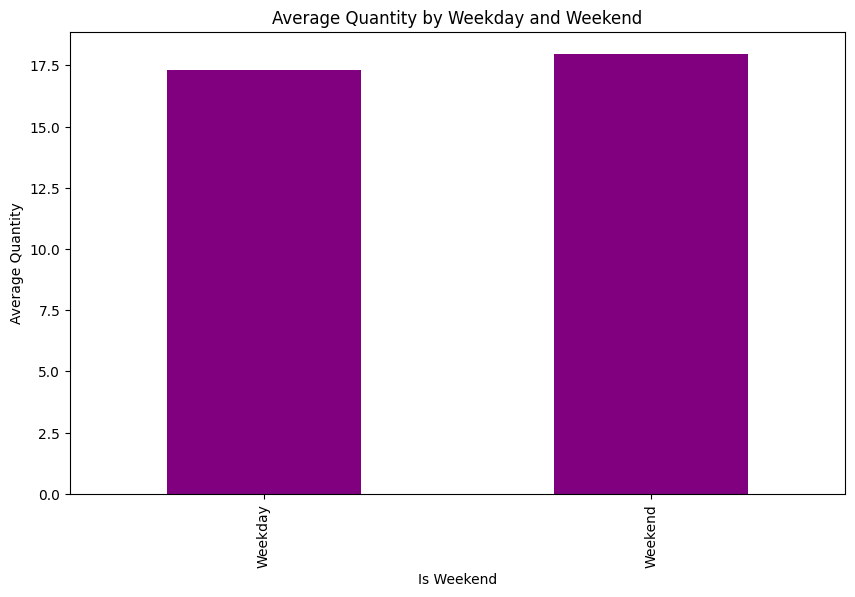

In [178]:
# @title Quantity by weekday vs weekend average { form-width: "20px" }
plt.figure(figsize=(10, 6))
merged_df.groupby('Is Weekend')['quantity1'].mean().plot(kind='bar', color='purple')
plt.title('Average Quantity by Weekday and Weekend')
plt.xlabel('Is Weekend')
plt.ylabel('Average Quantity')
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'])
plt.show()


The graph shows the average quantity purchased on weekdays vs. weekends. The average quantity is about the same on both weekdays and weekend, with weekend being slightly higher.





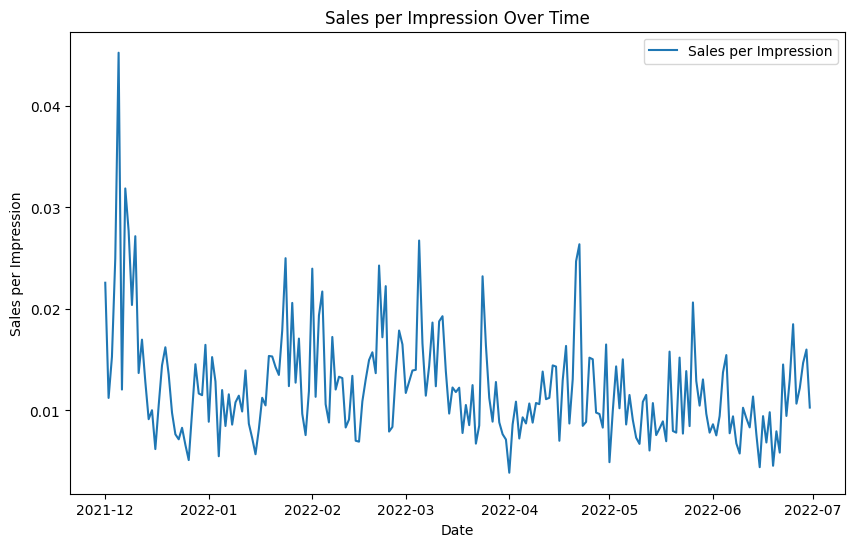

In [179]:
# @title Sales per Impression over time{ form-width: "20px" }
plt.figure(figsize=(10, 6))
plt.plot(merged_df.index, merged_df['Sales_per_Impression'], label='Sales per Impression')
plt.title('Sales per Impression Over Time')
plt.xlabel('Date')
plt.ylabel('Sales per Impression')
plt.legend()
plt.show()


The sales per impressions is experiencing a general downward trend, with a few fluctuations. The low points of sales per impressions are observed in July 2022 with 0.01, May 2022 and June 2022 both with 0.02. On the other hand, the high points of sales per impressions are seen in December 2021 with 0.05 and January 2022 with 0.04.

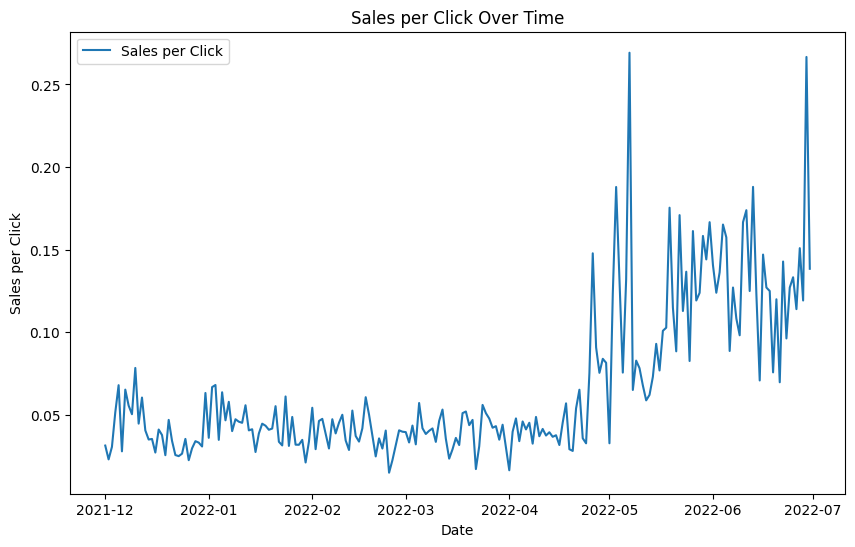

In [180]:
# @title Sales per Click over time { form-width: "20px" }
plt.figure(figsize=(10, 6))
plt.plot(merged_df.index, merged_df['Sales_per_Click'], label='Sales per Click')
plt.title('Sales per Click Over Time')
plt.xlabel('Date')
plt.ylabel('Sales per Click')
plt.legend()
plt.show()


The sales per click is relatively low and stable from December 2021 to March 2022. The sales per click then experiences a significant spike in May 2022 and remains high until July 2022.

<function matplotlib.pyplot.show(close=None, block=None)>

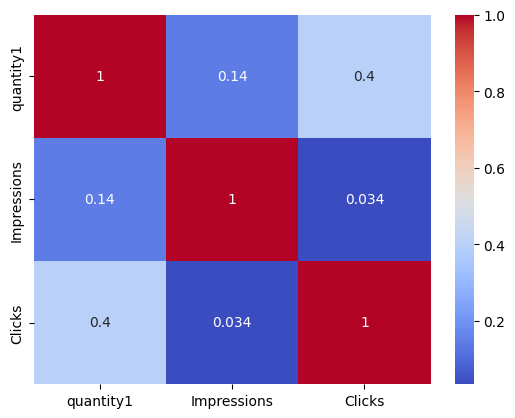

In [181]:
# @title Correlation betn variables { form-width: "20px" }
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = merged_df[['quantity1', 'Impressions', 'Clicks']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show

1. There is a strong positive correlation between Impressions and Clicks. This is expected, as more impressions usually lead to more clicks.
2. There is a moderate positive correlation between quantity1 and Clicks. This indicates that there is a moderate relationship between quantity1 and clicks.
3. There is a weak positive correlation between quantity1 and Impressions. This means there is a very weak relationship between the two.


# **Time series analysis**

### **Validating hypotheses**

In [182]:
# @title Stationarity { form-width: "20px" }

from statsmodels.tsa.stattools import adfuller
import pandas as pd # Import pandas for data manipulation

def check_stationarity(series):
  # Handle missing or infinite values
  series = series.replace([np.inf, -np.inf], np.nan).dropna()

  result = adfuller(series)
  print(f'ADF Statistic: {result[0]}')
  print(f'p-value: {result[1]}')
  for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

check_stationarity(merged_df['quantity1'])
check_stationarity(merged_df['Impressions'])
check_stationarity(merged_df['Clicks'])

ADF Statistic: -4.354530231978855
p-value: 0.00035693675948201967
Critical Values 1%: -3.4621857592784546
Critical Values 5%: -2.875537986778846
Critical Values 10%: -2.574231080806213
ADF Statistic: -5.696206110125867
p-value: 7.863580125889731e-07
Critical Values 1%: -3.46172743446274
Critical Values 5%: -2.8753374677799957
Critical Values 10%: -2.574124089081557
ADF Statistic: -0.8705717270828218
p-value: 0.797509057499528
Critical Values 1%: -3.4620315036789666
Critical Values 5%: -2.8754705024827127
Critical Values 10%: -2.5741950726860647


Quantity -> stationary, Impressions -> stationary, Clicks -> non-stationary

In [183]:
#Made clicks dataset stationary
series_diff = merged_df['Clicks'].diff().dropna()
check_stationarity(series_diff)

ADF Statistic: -14.224548848059223
p-value: 1.6358796342650808e-26
Critical Values 1%: -3.4620315036789666
Critical Values 5%: -2.8754705024827127
Critical Values 10%: -2.5741950726860647


Clicks data became stationary after 1st order differencing

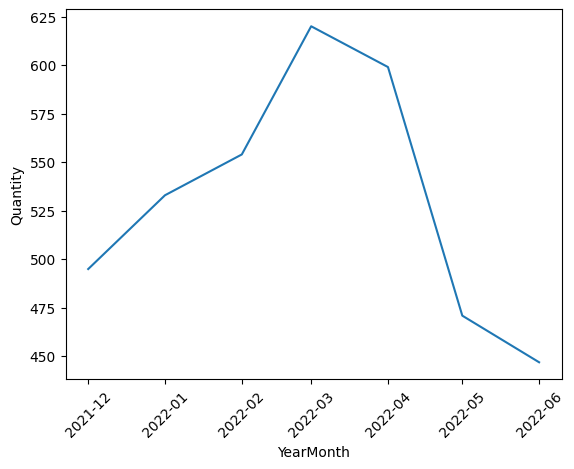

In [184]:
# @title Trend { form-width: "20px" }

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Aggregate the Quantity by Year and Month
monthly_data = merged_df.groupby(['Year', 'Month'])['Quantity'].sum().reset_index()

# Convert Year and Month to datetime format for regression analysis
monthly_data['YearMonth'] = pd.to_datetime(monthly_data[['Year', 'Month']].assign(day=1))

# Plot the monthly trend
sns.lineplot(x='YearMonth', y='Quantity', data=monthly_data)
plt.xticks(rotation=45)
plt.show()




The trend shows an upward trend from 2021-12 to 2022-03, peaking in 2022-03. There is a sharp decline in quantity from 2022-03 to 2022-05. The quantity continues to decline at a slower rate from 2022-05 to 2022-06.

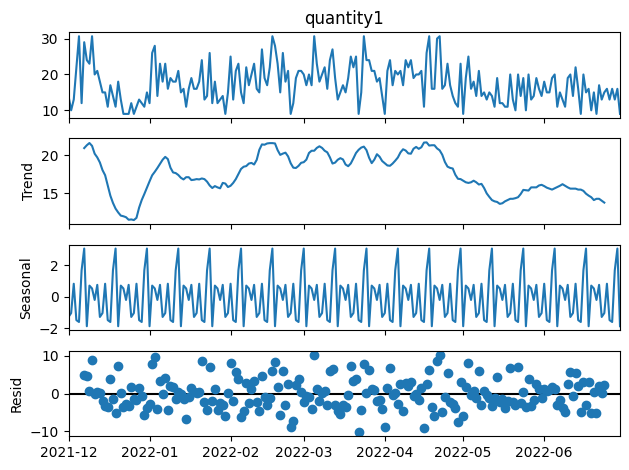

In [185]:
# @title Seasonality { form-width: "20px" }

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure 'Day Index' is the index and already in datetime format
merged_df.index = pd.to_datetime(merged_df.index)

# Perform seasonal decomposition
decomposition = seasonal_decompose(merged_df['quantity1'], model='additive', period=12)

# Plot the decomposition components
decomposition.plot()
plt.show()

The trend component shows that quantity1 is generally decreasing over time.
The seasonal component shows a slight repeating pattern that is not very strong.
The residuals appear to be random, which suggests that the model is capturing most of the variability in the time series.


<Figure size 1200x400 with 0 Axes>

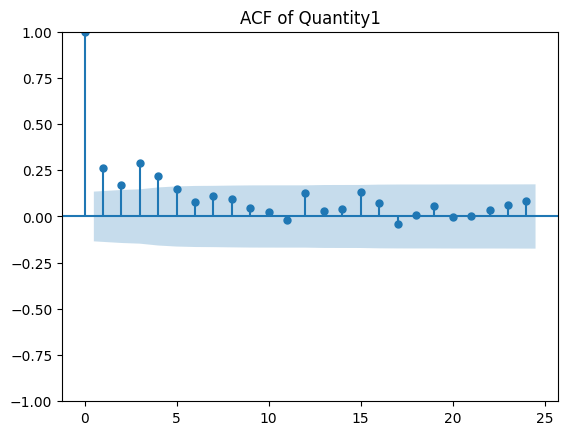

<Figure size 1200x400 with 0 Axes>

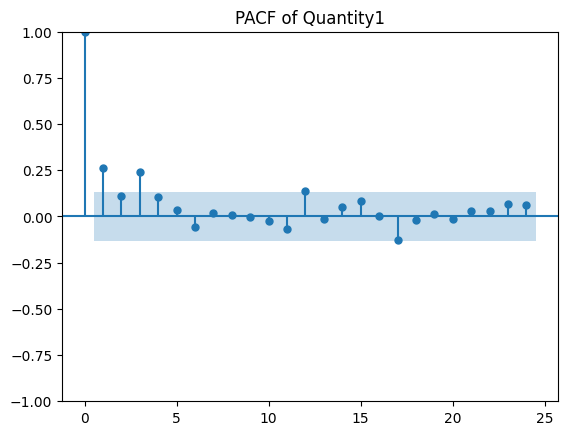

In [186]:
# @title Autocorrelation { form-width: "20px" }

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set the figure size for ACF plot to a more rectangular shape
plt.figure(figsize=(12, 4))
plot_acf(merged_df['quantity1'])
plt.title('ACF of Quantity1')
plt.show()

# Set the figure size for PACF plot to a more rectangular shape
plt.figure(figsize=(12, 4))
plot_pacf(merged_df['quantity1'])
plt.title('PACF of Quantity1')
plt.show()


The autocorrelation plot shows that the time series data has a strong positive autocorrelation at lag 1. The other lags are statistically insignificant. This indicates that the data is likely stationary and there is a strong correlation between the current value and the previous value.

The partial autocorrelation plot shows that there is a significant autocorrelation at lag 1, and then the autocorrelations decay to zero.

Pearson Correlation: 0.37604112043743887


<Figure size 1200x1000 with 0 Axes>

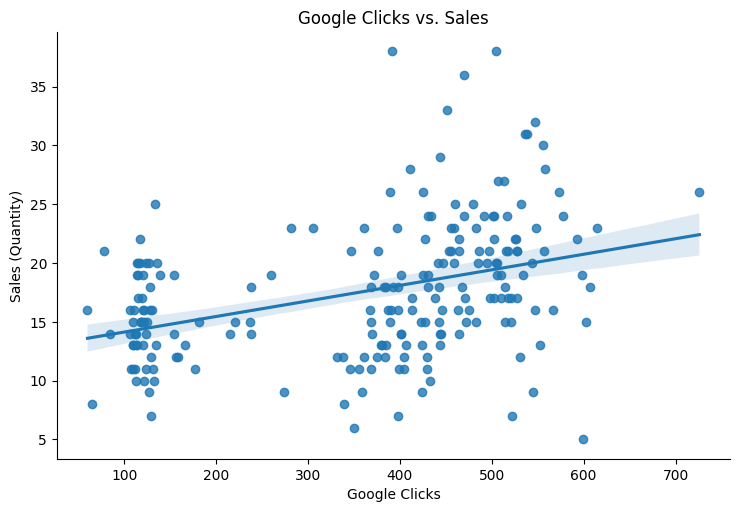

In [187]:
# @title Google clicks effect { form-width: "20px" }

import statsmodels.api as sm
import seaborn as sns

google_sales_corr = merged_df['Clicks'].corr(merged_df['Quantity'])
print(f'Pearson Correlation: {google_sales_corr}')

X = merged_df[['Clicks']]
y = merged_df['quantity1']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
# print(model.summary())

plt.figure(figsize=(12, 10))
sns.lmplot(x='Clicks', y='Quantity', data=merged_df, aspect=1.5)
plt.title('Google Clicks vs. Sales')
plt.xlabel('Google Clicks')
plt.ylabel('Sales (Quantity)')
plt.show()

Graph shows a positive correlation between sales and google clicks indicating more number of google clicks leads to increase in sales.

6. Facebook impressions effect



Pearson Correlation: 0.1359426271127098


<Figure size 1200x1000 with 0 Axes>

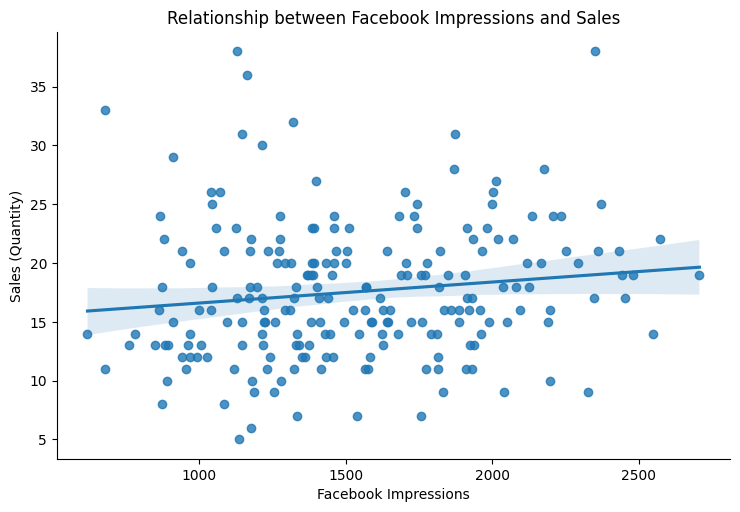

In [188]:
# @title Facebook impressions effect{ form-width: "20px" }

facebook_sales_corr = merged_df['Impressions'].corr(merged_df['Quantity'])
print(f'Pearson Correlation: {facebook_sales_corr}')

X = merged_df[['Impressions']]
y = merged_df['quantity1']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
# print(model.summary())

plt.figure(figsize=(12, 10))
sns.lmplot(x='Impressions', y='Quantity', data=merged_df, aspect=1.5)
plt.title('Relationship between Facebook Impressions and Sales')
plt.xlabel('Facebook Impressions')
plt.ylabel('Sales (Quantity)')
plt.show()


Graph shows a positive correlation between sales and facebook impressions indicating more number of facebook impressions leads to increase in sales. But has less effect on sales quantity compared to google clicks column.

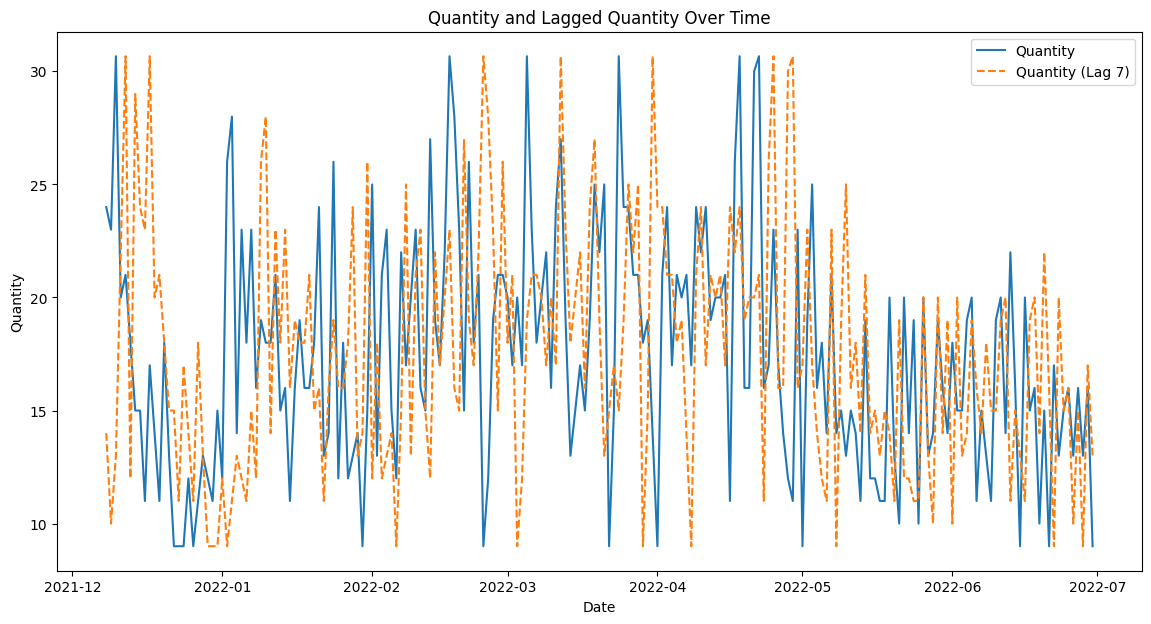

In [189]:
# @title Quantity and lagged quantity over time { form-width: "20px" }
import matplotlib.pyplot as plt

# Create lagged feature
merged_df['quantity_lag7'] = merged_df['quantity1'].shift(7)

# Drop rows with NaN values created by shifting
merged_df.dropna(inplace=True)

# Plot the original and lagged quantity
plt.figure(figsize=(14, 7))
plt.plot(merged_df.index, merged_df['quantity1'], label='Quantity')
plt.plot(merged_df.index, merged_df['quantity_lag7'], label='Quantity (Lag 7)', linestyle='--')
plt.title('Quantity and Lagged Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()


The plot shows the original quantity and lagged quantity (lag 7) over time. The lag 7 quantity appears to follow the same pattern as the original quantity. This indicates that the series may be autocorrelated. This is useful information for forecasting, as it suggests that past values of the quantity can be used to predict future values.

### **Modelling**

In [190]:
# @title Replacing values with zero to its mean { form-width: "20px" }

for column in merged_df.select_dtypes(include=['number']):
    mean_value = merged_df[column].mean()
    merged_df[column] = merged_df[column].replace(0, mean_value)

In [191]:
# merged_df.describe()

In [192]:
# # @title Splitting data into train, validation, test set { form-width: "20px" }

# Calculate the split indices
train_size = int(0.6 * len(merged_df))
val_size = int(0.2 * len(merged_df))
test_size = len(merged_df) - train_size - val_size

# Split the merged_df
train_df = merged_df.iloc[:train_size]
val_df = merged_df.iloc[train_size:train_size + val_size]
test_df = merged_df.iloc[train_size + val_size:]

print("Train Data Size:\t", len(train_df))
print("Validation Data Size:\t", len(val_df))
print("Test Data Size:\t\t", len(test_df))


Train Data Size:	 123
Validation Data Size:	 41
Test Data Size:		 41


In [193]:
# Count NaN values in each column
missing_values = merged_df.isnull().sum()

# Print the count of missing values
print(missing_values)

Quantity                0
Impressions             0
Clicks                  0
quantity1               0
Year                    0
Month                   0
Quarter                 0
Weekday                 0
Is Weekend              0
Is Holiday              0
Day Type                0
Sales_per_Impression    0
Sales_per_Click         0
Quantity_Lag1           0
Quantity_Lag7           0
Weekday_Monday          0
Weekday_Tuesday         0
Weekday_Wednesday       0
Weekday_Thursday        0
Weekday_Friday          0
Weekday_Saturday        0
Weekday_Sunday          0
Month_January           0
Month_February          0
Month_March             0
Month_April             0
Month_May               0
Month_June              0
Month_July              0
Month_August            0
Month_September         0
Month_October           0
Month_November          0
Month_December          0
quantity_lag7           0
dtype: int64


In [194]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import numpy as np

def evaluate_metrics(actual, predicted, n_features=1):
    def calculate_mape(actual_values, predicted_values):
        actual_values = np.array(actual_values)
        predicted_values = np.array(predicted_values)
        abs_percentage_error = np.abs((actual_values - predicted_values) / actual_values)
        abs_percentage_error[np.isnan(abs_percentage_error)] = 0
        mape = np.mean(abs_percentage_error) * 100
        return mape

    rmse = sqrt(mean_squared_error(actual, predicted))
    mape = calculate_mape(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    n_samples = len(actual)
    adjusted_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)

    return {
        'RMSE': rmse,
        'MAPE': mape,
        'MAE': mae,
        'R2': r2,
        'Adjusted R2': adjusted_r2
    }


def plot_predictions_vs_actuals(actual_data, predicted_sets, titles, colors, model_name):
    plt.figure(figsize=(10, 6))

    # Plot actual values using the entire index
    plt.plot(actual_data.index, actual_data['quantity1'], label='Actual Data', color='coral')

    # Plot predicted values for each set
    for i, (predicted, title, color) in enumerate(zip(predicted_sets, titles, colors)):
        # Select the appropriate portion of the index for each prediction set
        if title == 'Train':
            index = actual_data.index[len(actual_data)-len(predicted):] # Use the last portion of the index for training predictions
        elif title == 'Validation':
            index = actual_data.index[len(train_df):len(train_df) + len(predicted)]
        else: # Test
            index = actual_data.index[len(train_df) + len(val_df):]

        plt.plot(index, predicted, label=f'{title} Predictions', color=color, linestyle='--')

    # Set labels, legend, grid, and title
    plt.xlabel("Date")
    plt.ylabel("quantity1")
    plt.legend()
    plt.grid(True)
    plt.title(f"{model_name} - Predictions vs. Actuals")
    plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Onl

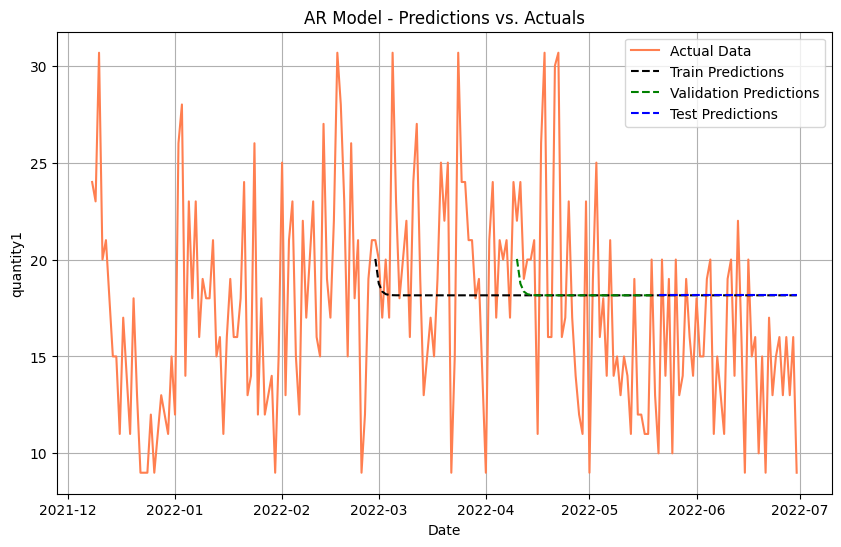

Train Metrics:
{'RMSE': 5.288717712196095, 'MAPE': 27.28572841001908, 'MAE': 4.322070954841599, 'R2': 0.008298178432910808, 'Adjusted R2': 0.00010229561004226895}

Validation Metrics:
{'RMSE': 5.598096461518345, 'MAPE': 29.445265276665584, 'MAE': 4.6255516284951295, 'R2': 0.004186745048672114, 'Adjusted R2': -0.02134692815520811}

Test Metrics:
{'RMSE': 4.628655498617699, 'MAPE': 31.52678628502587, 'MAE': 3.8589124350259936, 'R2': -0.7723672908233157, 'Adjusted R2': -0.8178126059726314}




In [195]:
# @title AR model { form-width: "20px" }

from statsmodels.tsa.ar_model import AutoReg # Import AutoReg instead of AR

# Select target variable
target_variable = train_df['quantity1']
# Fit AR model with order (p) based on your analysis (e.g., PACF plot)
ar_model = AutoReg(target_variable, lags=1).fit()  # Use AutoReg and specify 'lags'

# Generate predictions for train set
predictions_train = ar_model.predict(start=len(train_df), end=len(train_df) + len(train_df) - 1)
# Evaluate and plot metrics for validation set
metrics_train = evaluate_metrics(train_df['quantity1'], predictions_train, n_features=1)
rmse_train, mape_train, mae_train = metrics_train['RMSE'], metrics_train['MAPE'], metrics_train['MAE']

# Generate predictions for validation set
predictions_val = ar_model.predict(start=len(train_df), end=len(train_df) + len(val_df) - 1)
# Evaluate and plot metrics for validation set
metrics_val = evaluate_metrics(val_df['quantity1'], predictions_val, n_features=1)
rmse_val, mape_val, mae_val,r2 ,adjusted_r2 = metrics_val['RMSE'], metrics_val['MAPE'], metrics_val['MAE'], metrics_val['R2'], metrics_val['Adjusted R2']

# Generate predictions for test set
predictions_test = ar_model.predict(start=len(train_df) + len(val_df), end=len(merged_df) - 1)
# Evaluate and plot metrics for test
metrics_test = evaluate_metrics(test_df['quantity1'], predictions_test, n_features=1)
rmse_test, mape_test, mae_test, r2, adjusted_r2 = metrics_test['RMSE'], metrics_test['MAPE'], metrics_test['MAE'], metrics_test['R2'], metrics_test['Adjusted R2']

plot_predictions_vs_actuals(merged_df,
                           [predictions_train, predictions_val, predictions_test],
                           ['Train', 'Validation', 'Test'],
                           ['black', 'green', 'blue'],
                           'AR Model')
print("Train Metrics:")
print(metrics_train)
print("\nValidation Metrics:")
print(metrics_val)
print("\nTest Metrics:")
print(metrics_test)
print("\n")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


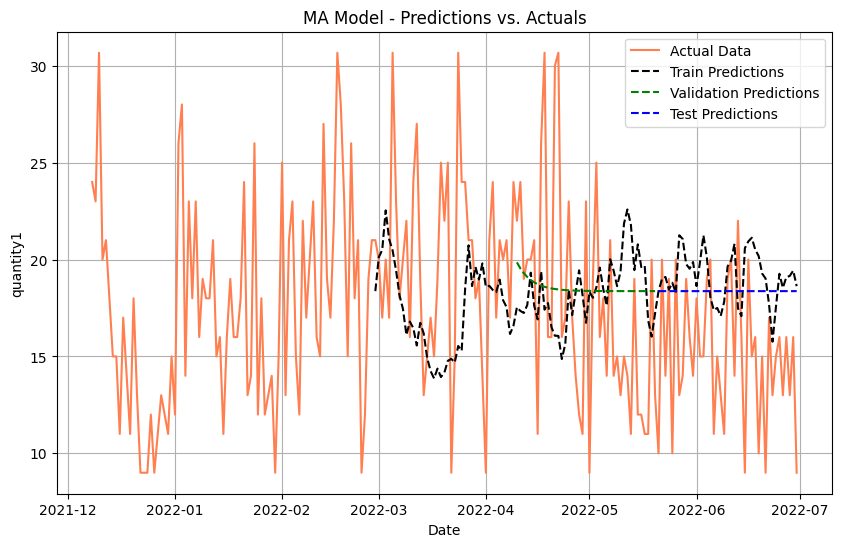

Train Metrics:
{'RMSE': 4.964562623119644, 'MAPE': 24.66845592636903, 'MAE': 3.9993425818686026, 'R2': 0.12613906814570253, 'Adjusted R2': 0.11891707697335296}

Validation Metrics:
{'RMSE': 5.59258606232257, 'MAPE': 29.87102022707865, 'MAE': 4.617730295747355, 'R2': 0.006146206774157226, 'Adjusted R2': -0.019337223821377147}

Test Metrics:
{'RMSE': 4.774289722183573, 'MAPE': 32.51325807160477, 'MAE': 3.9697577139693925, 'R2': -0.8856520173531239, 'Adjusted R2': -0.9340020690801272}




In [196]:
# @title MA model { form-width: "20px" }

from statsmodels.tsa.arima.model import ARIMA

# Select target variable
target_variable = train_df['quantity1']
# Define the MA order (q) based on your analysis (e.g., ACF plot)
order = (1, 0, 1)  # MA(1) model

# Fit the MA model on the training data
ma_model = ARIMA(target_variable, order=order).fit()

# Generate predictions for train set
predictions_train = ma_model.predict(start=0, end=len(train_df) - 1)
metrics_train = evaluate_metrics(train_df['quantity1'], predictions_train, n_features = 1)

# Generate predictions for validation set
predictions_val = ma_model.predict(start=len(train_df), end=len(train_df) + len(val_df) - 1)
metrics_val = evaluate_metrics(val_df['quantity1'], predictions_val, n_features=1)

# Generate predictions for test set
predictions_test = ma_model.predict(start=len(train_df) + len(val_df), end=len(merged_df) - 1)
metrics_test = evaluate_metrics(test_df['quantity1'], predictions_test, n_features=1)

plot_predictions_vs_actuals(merged_df,
                           [predictions_train, predictions_val, predictions_test],
                           ['Train', 'Validation', 'Test'],
                           ['black', 'green', 'blue'],
                           'MA Model')
print("Train Metrics:")
print(metrics_train)
print("\nValidation Metrics:")
print(metrics_val)
print("\nTest Metrics:")
print(metrics_test)
print("\n")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


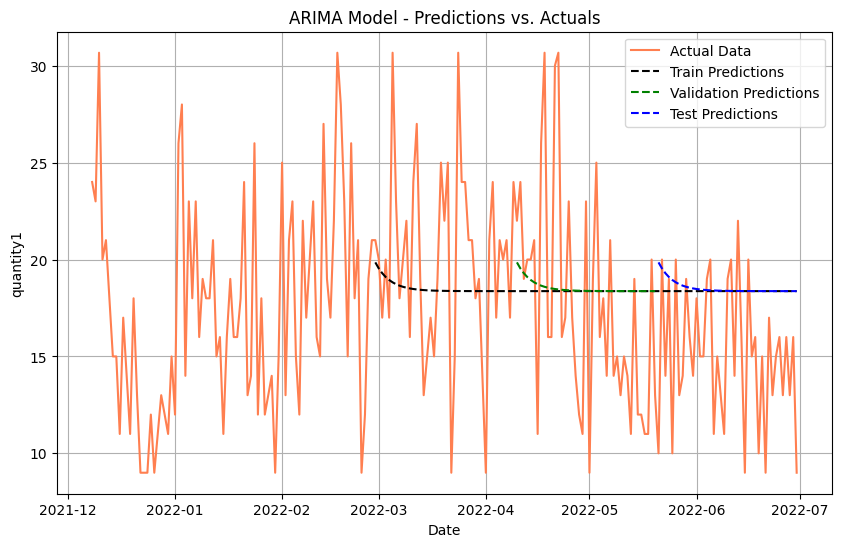

Train Metrics:
{'RMSE': 5.287396806281849, 'MAPE': 27.767498739374712, 'MAE': 4.34139280006358, 'R2': 0.008793489881609662, 'Adjusted R2': 0.0006017005417883192}

Validation Metrics:
{'RMSE': 5.59258606232257, 'MAPE': 29.87102022707865, 'MAE': 4.617730295747355, 'R2': 0.006146206774157226, 'Adjusted R2': -0.019337223821377147}

Test Metrics:
{'RMSE': 4.906354242119874, 'MAPE': 33.09677141945364, 'MAE': 4.0140826227181385, 'R2': -0.991415176503488, 'Adjusted R2': -1.0424771041061414}




In [197]:
# @title ARIMA model { form-width: "20px" }

# ARIMA Model
target_variable = train_df['quantity1']

# Fit the ARIMA model on the training data
ar_model = ARIMA(target_variable, order=(1,0,1))
ar_model_fit = ar_model.fit()

# Make predictions on validation and test sets (if applicable)
ar_predictions_train = ar_model_fit.forecast(steps=len(train_df), dynamic=False)
ar_predictions_val = ar_model_fit.forecast(steps=len(val_df), dynamic=False)
ar_predictions_test = ar_model_fit.forecast(steps=len(test_df), dynamic=False)

# **Ensure indices of actual and predicted match**
y_train = train_df['quantity1']  # Assuming 'quantity1' is the target variable in training set
y_val = val_df['quantity1']  # Assuming 'quantity1' is the target variable in validation set
y_test = test_df['quantity1']  # Assuming 'quantity1' is the target variable in test set

# Evaluate and plot metrics for ARIMA model
metrics_train = evaluate_metrics(y_train, ar_predictions_train)
metrics_val = evaluate_metrics(y_val, ar_predictions_val)
metrics_test = evaluate_metrics(y_test, ar_predictions_test)

plot_predictions_vs_actuals(merged_df,
                           [ar_predictions_train, ar_predictions_val, ar_predictions_test],
                           ['Train', 'Validation', 'Test'],
                           ['black', 'green', 'blue'],
                           'ARIMA Model')
print("Train Metrics:")
print(metrics_train)
print("\nValidation Metrics:")
print(metrics_val)
print("\nTest Metrics:")
print(metrics_test)
print("\n")

In [198]:
!pip install pmdarima

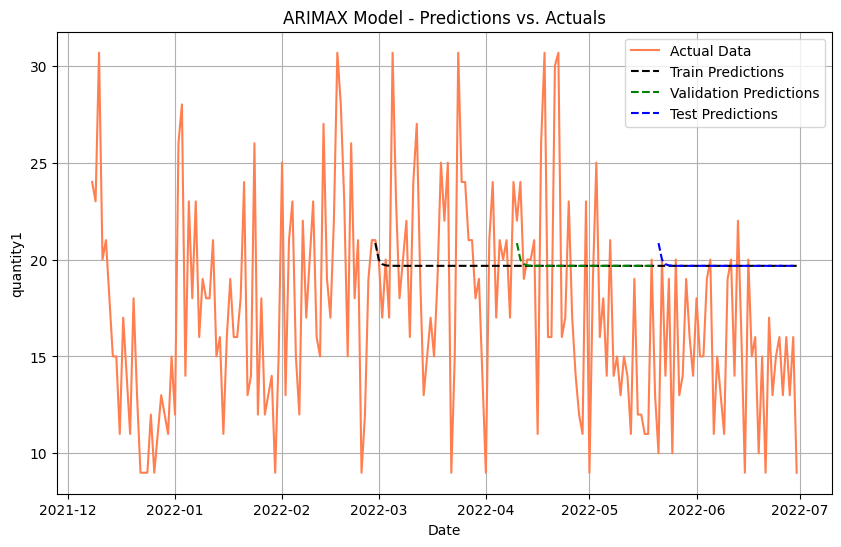

Train set:
{'RMSE': 5.501952574985804, 'MAPE': 30.770723507249592, 'MAE': 4.544050848999468, 'R2': -0.07328243578507543, 'Adjusted R2': -0.0821525385601587}
Validation set:
{'RMSE': 5.969571281578952, 'MAPE': 34.03647840911185, 'MAE': 5.016132824801826, 'R2': -0.13235716482323467, 'Adjusted R2': -0.16139196392126642}
Test set:
{'RMSE': 5.800367849671372, 'MAPE': 39.41800112594462, 'MAE': 4.793009515037803, 'R2': -1.783268363627641, 'Adjusted R2': -1.854634219105273}


In [199]:
# @title Arimax model { form-width: "20px" }
# Select exogenous variables
exog_train = train_df[[ 'Clicks', 'Impressions', 'Quantity_Lag1']]
exog_val = val_df[[ 'Clicks', 'Impressions', 'Quantity_Lag1']]
exog_test = test_df[[ 'Clicks', 'Impressions', 'Quantity_Lag1']]

from pmdarima import auto_arima

# Fit the auto ARIMA model (replace with your data)
auto_model = auto_arima(train_df['quantity1'], exogenous=exog_train, order=(1, 0, 1), error_action='ignore', suppress_warnings=True)

# Forecast on all sets
train_forecast = auto_model.predict(n_periods=len(train_df), exogenous=exog_train)
val_forecast = auto_model.predict(n_periods=len(val_df), exogenous=exog_val)
test_forecast = auto_model.predict(n_periods=len(test_df), exogenous=exog_test)

metrics_train = evaluate_metrics(train_df['quantity1'], train_forecast)
metrics_val = evaluate_metrics(val_df['quantity1'], val_forecast)
metrics_test = evaluate_metrics(test_df['quantity1'], test_forecast)

plot_predictions_vs_actuals(merged_df,
                           [train_forecast, val_forecast, test_forecast],
                           ['Train', 'Validation', 'Test'],
                           ['black', 'green', 'blue'],
                           'ARIMAX Model')
# Print evaluation metrics
print('Train set:')
print(metrics_train)
print('Validation set:')
print(metrics_val)
print('Test set:')
print(metrics_test)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


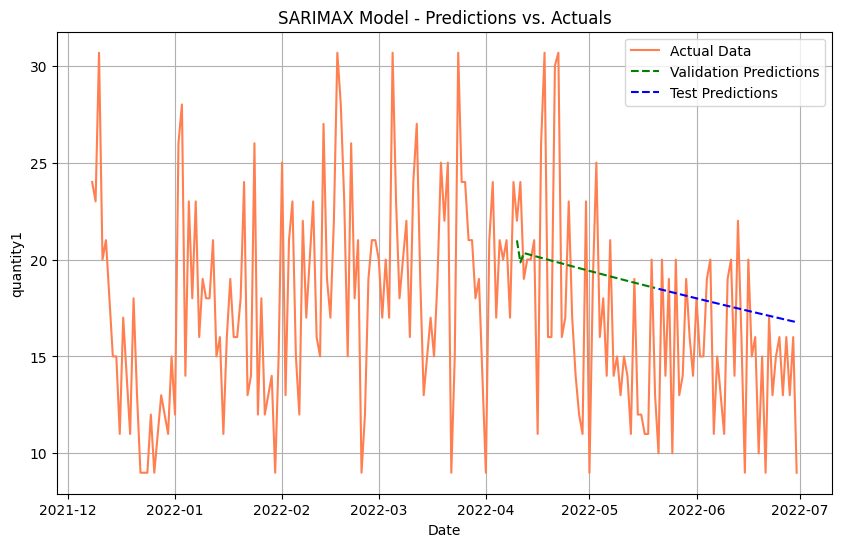


Validation Metrics:
RMSE: 5.6727
MAPE: 32.1329
MAE: 4.7757
R2: -0.0225
Adjusted R2: -0.0487

Test Metrics:
RMSE: 4.2458
MAPE: 28.2264
MAE: 3.4491
R2: -0.4913
Adjusted R2: -0.5295


In [200]:
# @title Sarimax model { form-width: "20px" }

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Select target variable
target_variable = train_df['quantity1']
# Define SARIMA model parameters (p, d, q, P, D, Q, s)
model = SARIMAX(
    target_variable,
    order=(1, 0, 1),  # Adjust (p, d, q) as needed
    seasonal_order=(0, 0, 1, 2)  # Adjust seasonal parameters (P, D, Q, s) if applicable
)

# Fit the model on training data
model_fit = model.fit()
# Generate predictions for validation set
predictions_val = model_fit.predict(start=len(train_df), end=len(train_df) + len(val_df) - 1)
# Generate predictions for test set
predictions_test = model_fit.predict(start=len(train_df) + len(val_df), end=len(merged_df) - 1)
plot_predictions_vs_actuals(merged_df,
                           [predictions_val, predictions_test],
                           ['Validation', 'Test'],
                           ['green', 'blue'],
                           'SARIMAX Model')
# Evaluate metrics for validation and test sets (assuming evaluate_metrics is defined)
if val_df['quantity1'].any() and predictions_val is not None:
    val_metrics = evaluate_metrics(val_df['quantity1'], predictions_val)
    print("\nValidation Metrics:")
    for metric, value in val_metrics.items():
        print(f"{metric}: {value:.4f}")  # Format output for better readability
else:
    print("Validation set evaluation skipped due to missing data or predictions.")
if test_df['quantity1'].any() and predictions_test is not None:
    test_metrics = evaluate_metrics(test_df['quantity1'], predictions_test)
    print("\nTest Metrics:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")
else:
    print("Test set evaluation skipped due to missing data or predictions.")


Validation RMSE: 4.9927
Validation MAE: 3.6674
Validation MAPE: 20.01%
Validation R2: 0.2079
Validation Adjusted R2: -0.1315


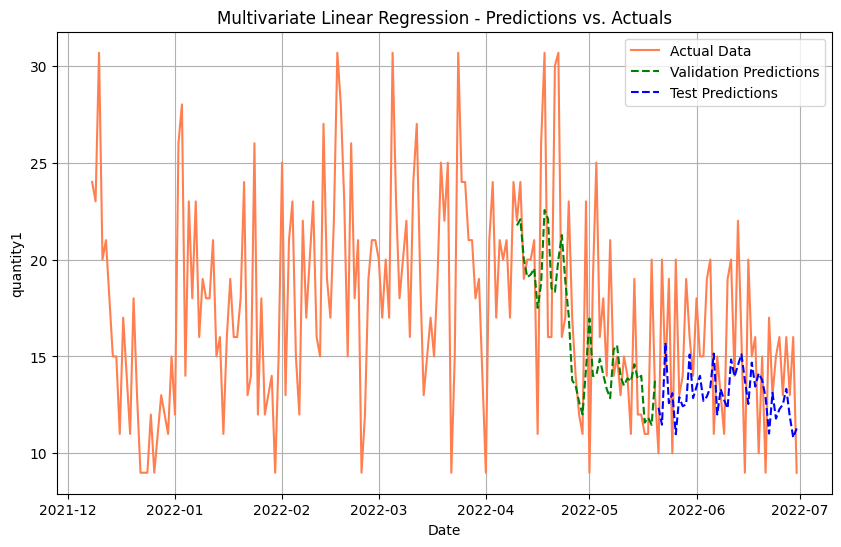

Test RMSE: 4.2573
Test MAE: 3.4226
Test MAPE: 22.08%
Test R2: -0.4994
Test Adjusted R2: -1.1420


In [201]:
# @title Mutlivariate linear regression model { form-width: "20px" }
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# Select features and target variable
target_variable = 'quantity1'

features = ['Month_January','Month_February','Month_June','Month_July','Weekday_Thursday','Weekday_Monday','Weekday_Saturday', 'Weekday_Sunday', 'Quarter','Clicks', 'Impressions', 'Quantity_Lag1']

# Extract features and target variable from training data
X_train = train_df[features]
y_train = train_df[target_variable]

# Similar extraction for validation and test data (optional)
# Make sure to create the new features in val_df and test_df as well
X_val = val_df[features]
y_val = val_df[target_variable]
X_test = test_df[features]
y_test = test_df[target_variable]

#  Impute NaN values using a strategy (e.g., mean):
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)
y_train = y_train.fillna(y_train.mean())
y_val = y_val.fillna(y_val.mean())
y_test = y_test.fillna(y_test.mean())

# Create MLR model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on validation set
y_pred_val = model.predict(X_val)

# Evaluate model performance on validation set
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae_val = mean_absolute_error(y_val, y_pred_val)
mape_val = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
r2 = r2_score(y_val, y_pred_val)
adjusted_r2 = 1 - (1 - r2) * (len(y_val) - 1) / (len(y_val) - X_val.shape[1] - 1)

print(f"Validation RMSE: {rmse_val:.4f}")
print(f"Validation MAE: {mae_val:.4f}")
print(f"Validation MAPE: {mape_val:.2f}%")
print(f"Validation R2: {r2:.4f}")
print(f"Validation Adjusted R2: {adjusted_r2:.4f}")

# Make predictions on test set (optional
y_pred_test = model.predict(X_test)

# Evaluate model performance on test set
rmse_test = np.sqrt(mean_squared_error(test_df[target_variable], y_pred_test))
mae_test = mean_absolute_error(test_df[target_variable], y_pred_test)
mape_test = np.mean(np.abs((test_df[target_variable] - y_pred_test) / test_df[target_variable])) * 100
r2 = r2_score(test_df[target_variable], y_pred_test)
adjusted_r2 = 1 - (1 - r2) * (len(test_df[target_variable]) - 1) / (len(test_df[target_variable]) - X_test.shape[1] - 1)

plot_predictions_vs_actuals(merged_df,
                           [y_pred_val, y_pred_test],
                           ['Validation', 'Test'],
                           ['green', 'blue'],
                           'Multivariate Linear Regression')
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test MAPE: {mape_test:.2f}%")
print(f"Test R2: {r2:.4f}")
print(f"Test Adjusted R2: {adjusted_r2:.4f}")

## Comparison of models


| Model                       | Set          | RMSE   | MAPE      | MAE    | R2       | Adjusted R2 |
|-----------------------------|--------------|--------|-----------|--------|----------|-------------|
| AR Model                    | Validation   | 5.5981 | 29.4453%  | 4.6256 | 0.0042   | -0.0213     |
|                             | Test         | 4.6287 | 31.5268%  | 3.8589 | -0.7724  | -0.8178     |
| MA Model                    |Validation   | 5.5926 | 29.8710%  | 4.6177 | 0.0061   | -0.0193     |
|                             | Test         | 4.7743 | 32.5133%  | 3.9698 | -0.8857  | -0.9340     |
| ARIMA Model                 | Validation   | 5.5926 | 29.8710%  | 4.6177 | 0.0061   | -0.0193     |
|                             | Test         | 4.9064 | 33.0968%  | 4.0141 | -0.9914  | -1.0425     |
| ARIMAX Model                | Validation   | 5.9696 | 34.0365%  | 5.0161 | -0.1324  | -0.1614     |
|                             | Test         | 5.8004 | 39.4180%  | 4.7930 | -1.7833  | -1.8546     |
| SARIMAX Model               | Validation   | 5.6727 | 32.1329%  | 4.7757 | -0.0225  | -0.0487     |
|                             | Test         | 4.2458 | 28.2264%  | 3.4491 |  -0.4913  | -0.5295     |
| Multivariate Linear Model   | Validation   |4.9927 | 20.01%  | 3.6674 | 0.2079   | -0.1315     |
|                             | Test         | 4.2573 | 22.08%  | 3.4226 | -0.4994  | -1.1420    |


From above table we can conclude that **Multivariate linear regression model
(Validation set mape: 20.01%, Test set mape:22.08%)** gives the best result for validation and test set.

The important variables are:
1. January
2. February
3. June
4. July
5. Monday
6. Saturday
7. Sunday
8. Quarter
9. Impressions
10. Quantity_Lag1

The target variable for this analysis is the 'quantity1' column after outlier imputation.

Below is the graph showing actual data vs predictions of Multivariate linear regression model.

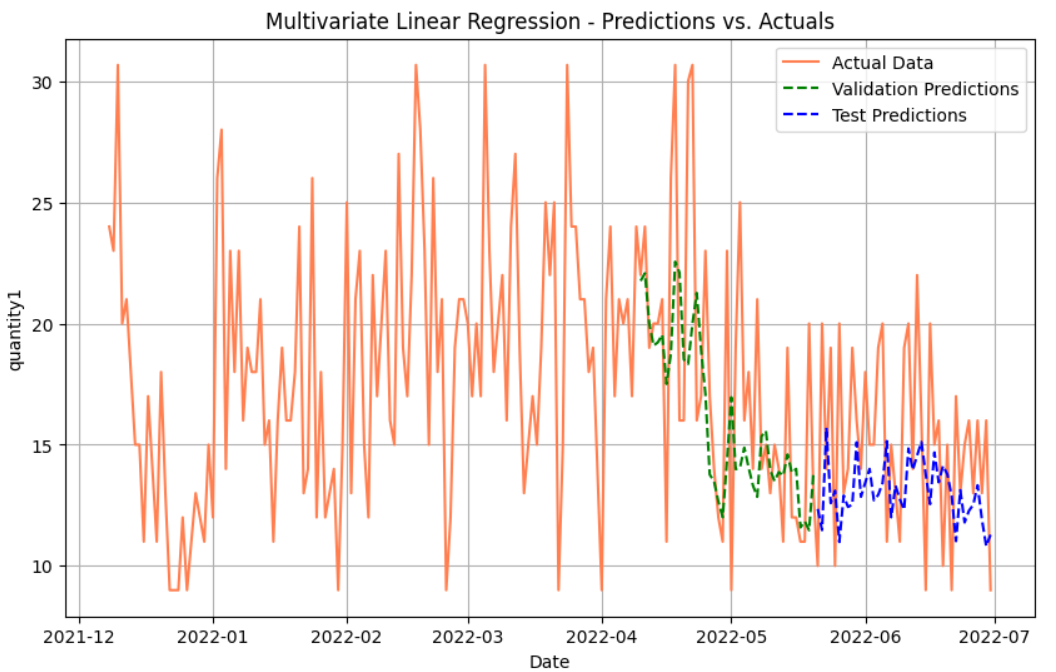